# Temu Kembali Informasi (Project Sentiment Analysis)

|NIM|Nama|
|-|-|
|2210511044|Rahman Ilyas Al Khafi|
|2210511056|Adinda Rizki Sya’bana Diva|
|2210511057|Nicolas Debrito|
|2210511058|Ika Kusuma Wardani|

## Download Library

In [1]:
# !pip install beautifulsoup4
# !pip install selenium
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install sastrawi
# !pip install nltk
# !pip install wordcloud
# !pip install scikit-learn
# !pip install tensorflow

## Import Library

In [2]:
import re
import nltk
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from collections import Counter
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from selenium import webdriver
from selenium.webdriver.common.by import By
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Embedding, LSTM, Dropout, Conv1D, MaxPooling1D

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

## Scraping Data

Data diambil dari ularang produk yang ada di Tokopedia pada tanggal 2 Juni 2024 pukul 22.30 WIB dengan detail

| Nama Toko | Grotic Official Shop|
|-|-|
| Nama barang | TWS Headset Bluetooth inpods 12 Earphone Wireless HIFI Sentuh Macaron - Biru Muda |
| Rating | 4.8/5.0 |

[https://www.tokopedia.com/grotic/tws-headset-bluetooth-inpods-12-earphone-wireless-hifi-sentuh-macaron-biru-muda/review](https://www.tokopedia.com/grotic/tws-headset-bluetooth-inpods-12-earphone-wireless-hifi-sentuh-macaron-biru-muda/review)

In [3]:
# review_url = "https://www.tokopedia.com/grotic/tws-headset-bluetooth-inpods-12-earphone-wireless-hifi-sentuh-macaron-biru-muda/review"

# review_dict = {'Username': [], 'Rating': [], 'Variant': [], 'Review': []}

# driver = webdriver.Chrome()
# driver.get(review_url)

# for i in range(49):
# 	soup = BeautifulSoup(driver.page_source, 'html.parser')
# 	review_div = soup.find_all('div', class_='css-1k41fl7')

# 	for review in review_div:
# 		try:
# 			reviewText = review.find(class_='css-ybiclm-unf-heading e1qvo2ff8').find('span').get_text(strip=True)
# 			reviewVariant = review.find(class_="css-1fp6f6k-unf-heading e1qvo2ff8").get_text(strip=True)
# 			reviewRating = review.find('div', {'data-testid': 'icnStarRating'}).get('aria-label')
# 			reviewUsername = review.find(class_="name").get_text(strip=True)

# 			review_dict['Review'].append(reviewText if reviewText else None)
# 			review_dict['Variant'].append(reviewVariant if reviewVariant else None)
# 			review_dict['Rating'].append(reviewRating if reviewRating else None)
# 			review_dict['Username'].append(reviewUsername if reviewUsername else None)
# 		except AttributeError:
# 			pass

# 	try:
# 		next_button = driver.find_element(By.XPATH, '//button[@aria-label="Laman berikutnya"]')
# 		next_button.click()
# 		time.sleep(2)
# 	except:
# 		break
        
# driver.quit()

# df = pd.DataFrame(review_dict)
# df

In [4]:
# df.to_excel('review_data.xlsx', index=False)

## Preproccess Cleaning & Filtering 

In [5]:
df = pd.read_excel('review_data.xlsx')
df

,Username,Rating,Variant,Review
0,Agus,bintang 5,Varian:Biru,barang sudah sampai
1,M***d,bintang 3,Varian:Biru,cepat habis
2,imron,bintang 5,Varian:Hitam,terima kasih
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, packing rapi, pengiriman cepat."
4,Fahmi,bintang 1,Varian:Putih,Rusak gabisa dipakai
...,...,...,...,...
2342,ika,bintang 5,Varian: Merah Muda,Barangnya original 👍 Nyaman dipakai lama Konek...
2343,A***n,bintang 5,Varian: Hitam,Nyaman dipakai lama. Suaranya jernih. Desainny...
2344,Rohaniah,bintang 5,Varian: Putih,sangat bagus dan sesuai dengan harga sangat ny...
2345,dzaky,bintang 5,Varian: Biru,baguss lahhh.... untuk harga segini


In [6]:
def remove_emoticons(text):
    emoticon_pattern = re.compile("["
								u"\U0001F600-\U0001F64F"
								u"\U0001F300-\U0001F5FF"
								u"\U0001F680-\U0001F6FF"
								u"\U0001F1E0-\U0001F1FF"
								u"\U00002702-\U000027B0"
								u"\U000024C2-\U0001F251"
								"]+", flags=re.UNICODE)

    return emoticon_pattern.sub(r'', text)

In [7]:
df['Review'] = df['Review'].apply(remove_emoticons)

Menggunakan word list bahasa indonesia untuk mencari kata slank yang terdapat pada review
[https://github.com/geovedi/indonesian-wordlist/blob/master/00-indonesian-wordlist.lst](https://github.com/geovedi/indonesian-wordlist/blob/master/00-indonesian-wordlist.lst)

In [8]:
review_word_only = df['Review'].apply(lambda x: re.sub(r'[^\w\s]|[\d]', '', x))

url = "https://raw.githubusercontent.com/geovedi/indonesian-wordlist/master/01-kbbi3-2001-sort-alpha.lst"
response = requests.get(url)

word_list = response.text.splitlines()

slank_word = []

for sentence in review_word_only:
    slank_word.extend([word for word in sentence.split() if word.lower() not in word_list])
    
slank_count = Counter(slank_word)
slank_count_df = pd.DataFrame(slank_count.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).reset_index(drop=True)

slank_count_df[:20]

,Word,Count
0,seller,195
1,packing,93
2,bgt,93
3,makasih,83
4,respon,72
5,udah,66
6,terimakasih,65
7,cepet,63
8,headset,63
9,bass,62


In [9]:
slank_count_df.to_excel('slank_word_list.xlsx', index=False)

In [10]:
fix_slank_word_df = pd.read_excel('fix_slank_word_list.xlsx')
fix_slank_word_df

,Word,Count,Fix Word
0,seller,195,penjual
1,packing,93,mengemas
2,bgt,93,sangat
3,makasih,83,terima kasih
4,respon,72,respons
...,...,...,...
86,pairing,10,memasangkan
87,thx,10,terima kasih
88,dengerin,10,mendengarkan
89,yaaa,10,ya


In [11]:
slank_dict = dict(zip(fix_slank_word_df['Word'], fix_slank_word_df['Fix Word']))

def replace_slank_words(review):
    words = review.split()
    replaced_words = [slank_dict.get(word, word) for word in words]
    return ' '.join(replaced_words)

df['Review'] = df['Review'].apply(replace_slank_words)
df

,Username,Rating,Variant,Review
0,Agus,bintang 5,Varian:Biru,barang sudah sampai
1,M***d,bintang 3,Varian:Biru,cepat habis
2,imron,bintang 5,Varian:Hitam,terima kasih
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat."
4,Fahmi,bintang 1,Varian:Putih,Rusak gabisa dipakai
...,...,...,...,...
2342,ika,bintang 5,Varian: Merah Muda,Barangnya asli Nyaman dipakai lama Koneksi ke ...
2343,A***n,bintang 5,Varian: Hitam,Nyaman dipakai lama. Suaranya jernih. Desainny...
2344,Rohaniah,bintang 5,Varian: Putih,sangat bagus dan sesuai dengan harga sangat ny...
2345,dzaky,bintang 5,Varian: Biru,bagus lahhh.... untuk harga sebegini


In [12]:
df = df[df['Review'].apply(lambda x: not any(kata in slank_word for kata in x.split()))]
df

,Username,Rating,Variant,Review
0,Agus,bintang 5,Varian:Biru,barang sudah sampai
1,M***d,bintang 3,Varian:Biru,cepat habis
2,imron,bintang 5,Varian:Hitam,terima kasih
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat."
5,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah"
...,...,...,...,...
2326,S***o,bintang 5,Varian: Putih,cepat respons
2327,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...
2329,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,..."
2330,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan..."


In [13]:
nltk.download('punkt')

df['Review_tokenize'] = [word_tokenize(review) for review in df['Review']]
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Username,Rating,Variant,Review,Review_tokenize
0,Agus,bintang 5,Varian:Biru,barang sudah sampai,"[barang, sudah, sampai]"
1,M***d,bintang 3,Varian:Biru,cepat habis,"[cepat, habis]"
2,imron,bintang 5,Varian:Hitam,terima kasih,"[terima, kasih]"
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat.","[Barang, bagus, ,, mengemas, rapi, ,, pengirim..."
5,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah","[unit, tidak, bisa, di, charge, ,, payah]"
...,...,...,...,...,...
2326,S***o,bintang 5,Varian: Putih,cepat respons,"[cepat, respons]"
2327,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...,"[terima, kasih, pengiriman, perangkat, jemala,..."
2329,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,...","[barang, sudah, diterima, ,, cepat, dan, kemas..."
2330,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan...","[baru, pertama, kali, order, disini, ,, sangat..."


In [14]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian') + list(punctuation) + ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'])
df['Review_filtered'] = df['Review_tokenize'].apply(lambda x: [kata for kata in x if kata.lower() not in stop_words])

df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Username,Rating,Variant,Review,Review_tokenize,Review_filtered
0,Agus,bintang 5,Varian:Biru,barang sudah sampai,"[barang, sudah, sampai]",[barang]
1,M***d,bintang 3,Varian:Biru,cepat habis,"[cepat, habis]","[cepat, habis]"
2,imron,bintang 5,Varian:Hitam,terima kasih,"[terima, kasih]","[terima, kasih]"
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat.","[Barang, bagus, ,, mengemas, rapi, ,, pengirim...","[Barang, bagus, mengemas, rapi, pengiriman, ce..."
5,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah","[unit, tidak, bisa, di, charge, ,, payah]","[unit, charge, payah]"
...,...,...,...,...,...,...
2326,S***o,bintang 5,Varian: Putih,cepat respons,"[cepat, respons]","[cepat, respons]"
2327,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...,"[terima, kasih, pengiriman, perangkat, jemala,...","[terima, kasih, pengiriman, perangkat, jemala,..."
2329,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,...","[barang, sudah, diterima, ,, cepat, dan, kemas...","[barang, diterima, cepat, kemasan, semoga, awe..."
2330,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan...","[baru, pertama, kali, order, disini, ,, sangat...","[kali, order, suka, ga, mengecewakan]"


In [15]:
stemmer = StemmerFactory().create_stemmer()
df['Review_stemmer'] = df['Review_filtered'].apply(lambda x: ' '.join([stemmer.stem(kata) for kata in x]))

df

,Username,Rating,Variant,Review,Review_tokenize,Review_filtered,Review_stemmer
0,Agus,bintang 5,Varian:Biru,barang sudah sampai,"[barang, sudah, sampai]",[barang],barang
1,M***d,bintang 3,Varian:Biru,cepat habis,"[cepat, habis]","[cepat, habis]",cepat habis
2,imron,bintang 5,Varian:Hitam,terima kasih,"[terima, kasih]","[terima, kasih]",terima kasih
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat.","[Barang, bagus, ,, mengemas, rapi, ,, pengirim...","[Barang, bagus, mengemas, rapi, pengiriman, ce...",barang bagus emas rapi kirim cepat
5,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah","[unit, tidak, bisa, di, charge, ,, payah]","[unit, charge, payah]",unit charge payah
...,...,...,...,...,...,...,...
2326,S***o,bintang 5,Varian: Putih,cepat respons,"[cepat, respons]","[cepat, respons]",cepat respons
2327,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...,"[terima, kasih, pengiriman, perangkat, jemala,...","[terima, kasih, pengiriman, perangkat, jemala,...",terima kasih kirim perangkat jemala nya cepat ...
2329,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,...","[barang, sudah, diterima, ,, cepat, dan, kemas...","[barang, diterima, cepat, kemasan, semoga, awe...",barang terima cepat kemas moga awet pakai suks...
2330,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan...","[baru, pertama, kali, order, disini, ,, sangat...","[kali, order, suka, ga, mengecewakan]",kali order suka ga kecewa


In [16]:
def is_empty_list(lst):
    return len(lst) == 0

filter_df = df[df['Review_filtered'].apply(lambda x: not is_empty_list(x))]

In [17]:
filter_df.to_excel('review_clean.xlsx', index=False)

## Analysis Text Mining

In [18]:
df = pd.read_excel('review_sentiment.xlsx')
df

,Username,Rating,Variant,Review,Review_tokenize,Review_filtered,Review_stemmer,Sentiment
0,Agus,bintang 5,Varian:Biru,barang sudah sampai,"['barang', 'sudah', 'sampai']",['barang'],barang,2
1,M***d,bintang 3,Varian:Biru,cepat habis,"['cepat', 'habis']","['cepat', 'habis']",cepat habis,0
2,imron,bintang 5,Varian:Hitam,terima kasih,"['terima', 'kasih']","['terima', 'kasih']",terima kasih,2
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat.","['Barang', 'bagus', ',', 'mengemas', 'rapi', '...","['Barang', 'bagus', 'mengemas', 'rapi', 'pengi...",barang bagus emas rapi kirim cepat,1
4,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah","['unit', 'tidak', 'bisa', 'di', 'charge', ',',...","['unit', 'charge', 'payah']",unit charge payah,0
...,...,...,...,...,...,...,...,...
1142,S***o,bintang 5,Varian: Putih,cepat respons,"['cepat', 'respons']","['cepat', 'respons']",cepat respons,1
1143,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...,"['terima', 'kasih', 'pengiriman', 'perangkat',...","['terima', 'kasih', 'pengiriman', 'perangkat',...",terima kasih kirim perangkat jemala nya cepat ...,1
1144,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,...","['barang', 'sudah', 'diterima', ',', 'cepat', ...","['barang', 'diterima', 'cepat', 'kemasan', 'se...",barang terima cepat kemas moga awet pakai suks...,1
1145,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan...","['baru', 'pertama', 'kali', 'order', 'disini',...","['kali', 'order', 'suka', 'ga', 'mengecewakan']",kali order suka ga kecewa,1


In [19]:
all_review = []
for kalimat in df['Review_stemmer']: 
		all_review.extend(str(kalimat).split())

([], [])

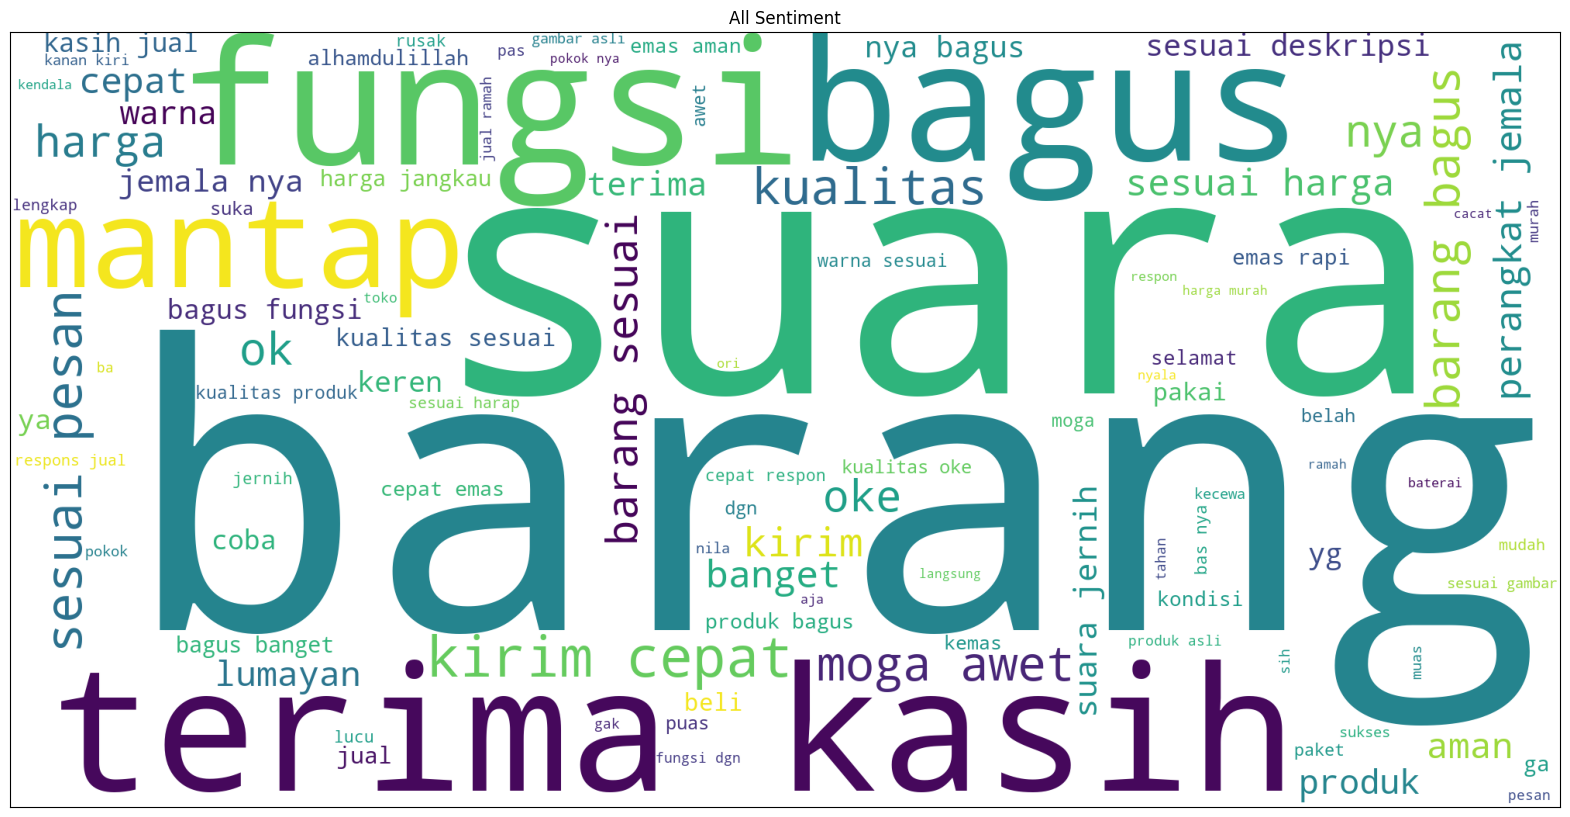

In [20]:
wordcloud = WordCloud(width=2000,
					height=1000,
					background_color='#FFFFFF',
					max_words = 100).generate(' '.join(all_review))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("All Sentiment")
plt.xticks([])
plt.yticks([])

In [21]:
word_count = Counter(all_review)
word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

word_count_df

,Word,Count
0,barang,424
5,bagus,357
18,sesuai,313
1,cepat,223
19,suara,221
...,...,...
356,nice,1
355,dicontohh,1
354,sember,1
352,kokoh,1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'barang'),
  Text(1, 0, 'bagus'),
  Text(2, 0, 'sesuai'),
  Text(3, 0, 'cepat'),
  Text(4, 0, 'suara'),
  Text(5, 0, 'fungsi'),
  Text(6, 0, 'terima'),
  Text(7, 0, 'kirim'),
  Text(8, 0, 'nya'),
  Text(9, 0, 'kualitas'),
  Text(10, 0, 'harga'),
  Text(11, 0, 'kasih'),
  Text(12, 0, 'mantap'),
  Text(13, 0, 'awet'),
  Text(14, 0, 'pesan'),
  Text(15, 0, 'moga'),
  Text(16, 0, 'banget'),
  Text(17, 0, 'produk'),
  Text(18, 0, 'oke'),
  Text(19, 0, 'jual')])

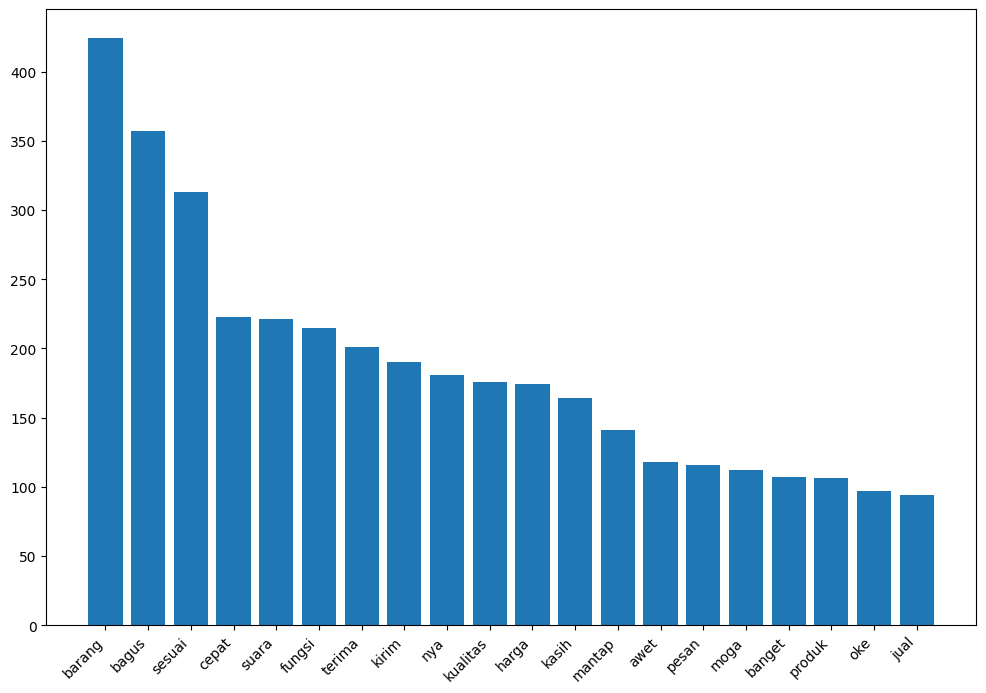

In [22]:
plt.figure(figsize=(12, 8))
plt.bar(word_count_df['Word'][:20], word_count_df['Count'][:20])
plt.xticks(rotation=45, ha='right')

([], [])

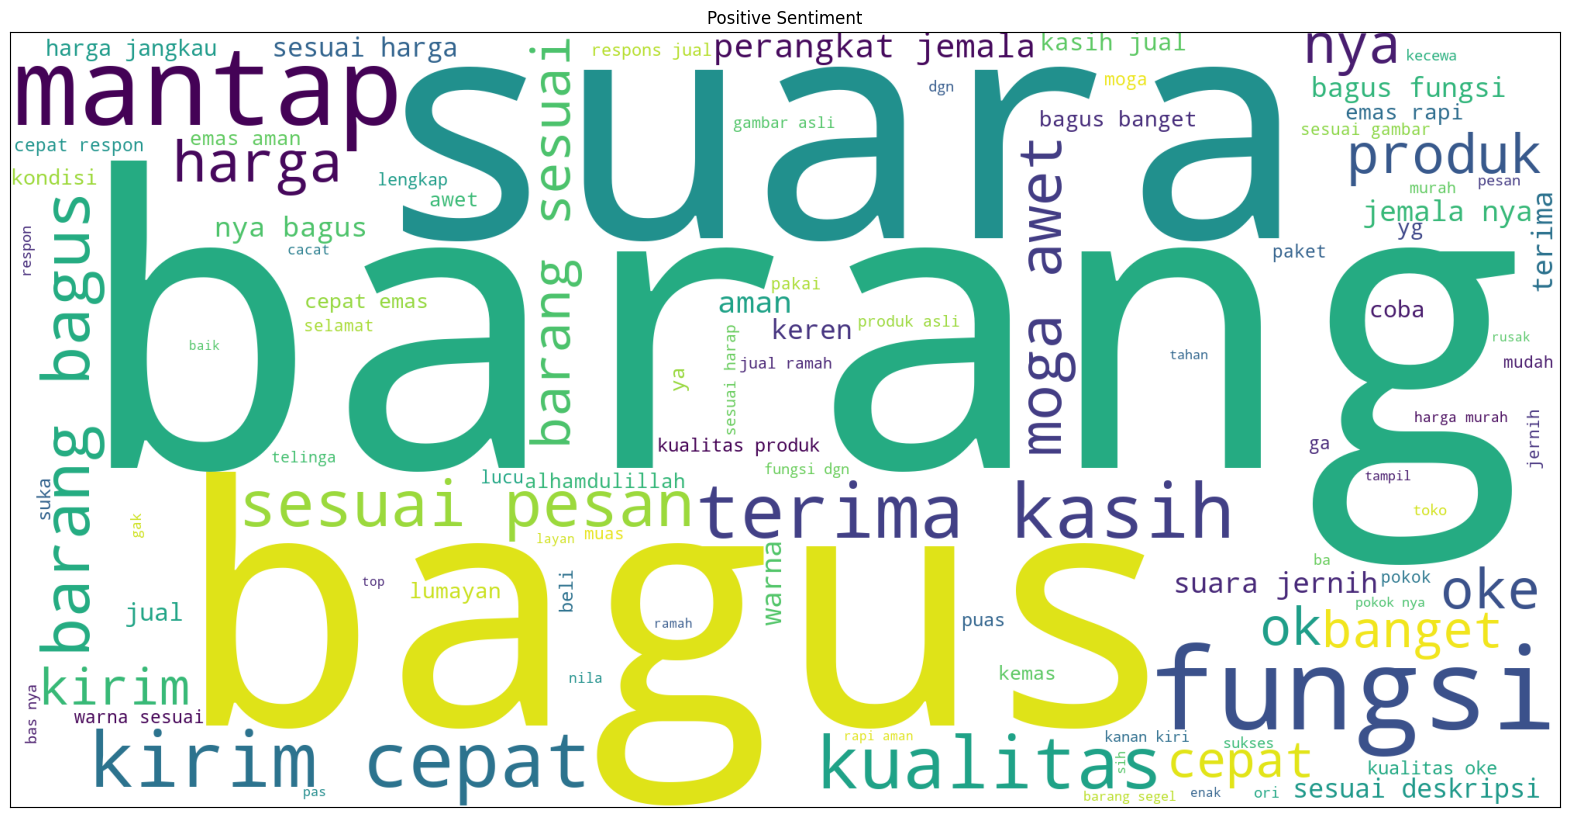

In [23]:
all_review_positif = []
positif_df = df[df['Sentiment'] == 1]

for kalimat in positif_df['Review_stemmer']: 
		all_review_positif.extend(str(kalimat).split())

wordcloud = WordCloud(width=2000,
					height=1000,
					background_color='#FFFFFF',
					max_words = 100).generate(' '.join(all_review_positif))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive Sentiment")
plt.xticks([])
plt.yticks([])

In [24]:
word_count = Counter(all_review_positif)
word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

word_count_df

,Word,Count
0,barang,367
1,bagus,340
11,sesuai,247
5,cepat,213
6,fungsi,195
...,...,...
336,keras,1
337,ampyuun,1
338,milih,1
339,duh,1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'barang'),
  Text(1, 0, 'bagus'),
  Text(2, 0, 'sesuai'),
  Text(3, 0, 'cepat'),
  Text(4, 0, 'fungsi'),
  Text(5, 0, 'suara'),
  Text(6, 0, 'kirim'),
  Text(7, 0, 'nya'),
  Text(8, 0, 'terima'),
  Text(9, 0, 'kualitas'),
  Text(10, 0, 'mantap'),
  Text(11, 0, 'harga'),
  Text(12, 0, 'kasih'),
  Text(13, 0, 'banget'),
  Text(14, 0, 'produk'),
  Text(15, 0, 'pesan'),
  Text(16, 0, 'awet'),
  Text(17, 0, 'moga'),
  Text(18, 0, 'jual'),
  Text(19, 0, 'oke')])

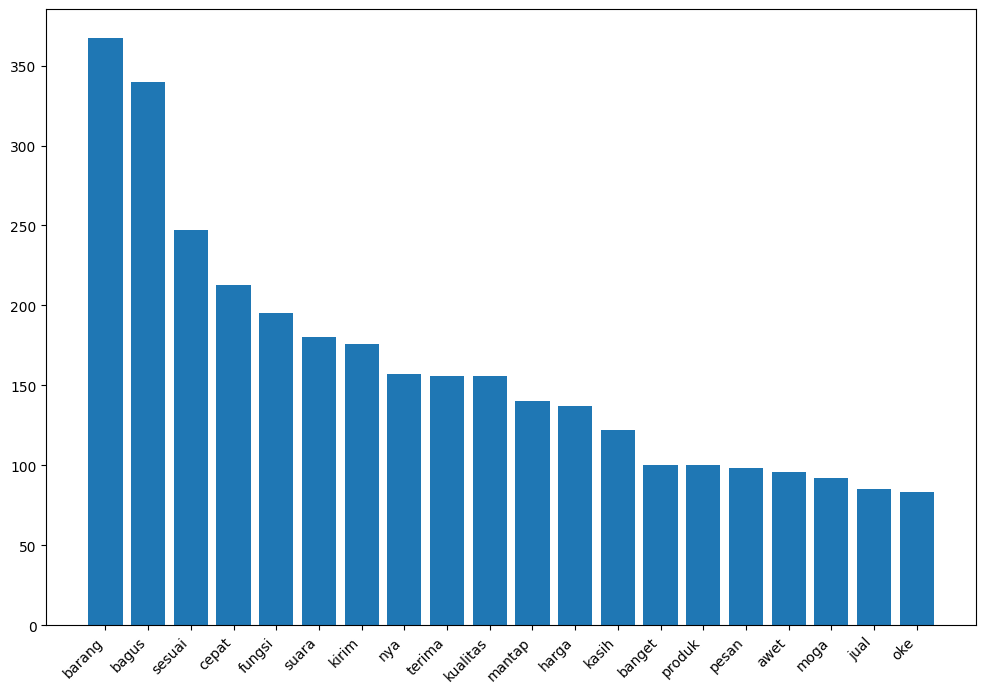

In [25]:
plt.figure(figsize=(12, 8))
plt.bar(word_count_df['Word'][:20], word_count_df['Count'][:20])
plt.xticks(rotation=45, ha='right')

([], [])

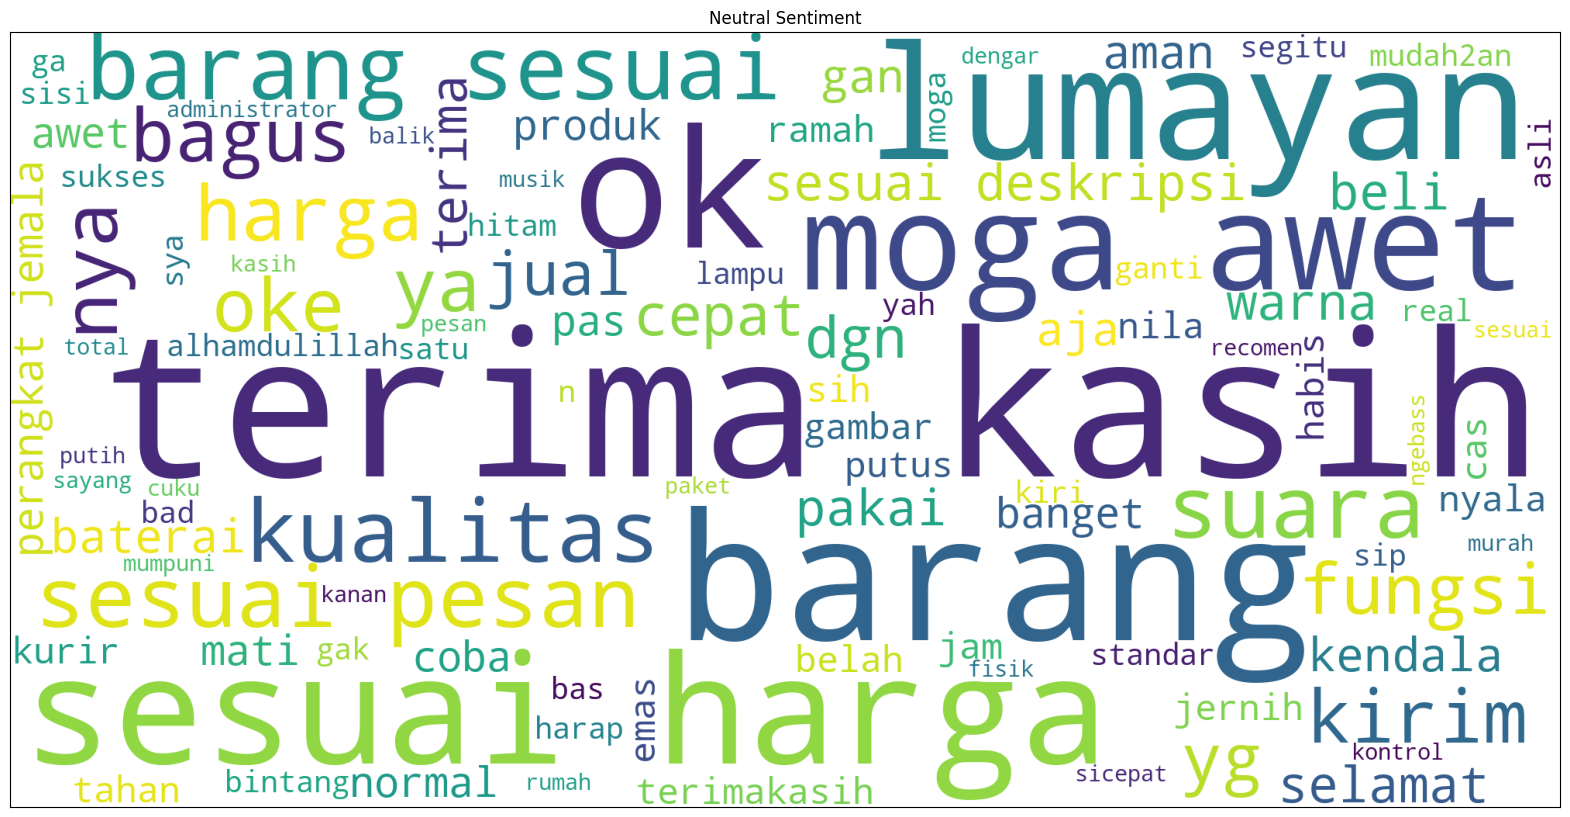

In [26]:
all_review_netral = []
netral_df = df[df['Sentiment'] == 2]

for kalimat in netral_df['Review_stemmer']: 
		all_review_netral.extend(str(kalimat).split())

wordcloud = WordCloud(width=2000,
					height=1000,
					background_color='#FFFFFF',
					max_words = 100).generate(' '.join(all_review_netral))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Neutral Sentiment")
plt.xticks([])
plt.yticks([])

In [27]:
word_count = Counter(all_review_netral)
word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

word_count_df

,Word,Count
9,sesuai,63
0,barang,47
1,terima,44
2,kasih,39
10,harga,35
...,...,...
108,h,1
106,lg,1
104,an,1
103,mudah,1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'sesuai'),
  Text(1, 0, 'barang'),
  Text(2, 0, 'terima'),
  Text(3, 0, 'kasih'),
  Text(4, 0, 'harga'),
  Text(5, 0, 'ok'),
  Text(6, 0, 'lumayan'),
  Text(7, 0, 'awet'),
  Text(8, 0, 'moga'),
  Text(9, 0, 'pesan'),
  Text(10, 0, 'kualitas'),
  Text(11, 0, 'suara'),
  Text(12, 0, 'nya'),
  Text(13, 0, 'oke'),
  Text(14, 0, 'kirim'),
  Text(15, 0, 'bagus'),
  Text(16, 0, 'ya'),
  Text(17, 0, 'fungsi'),
  Text(18, 0, 'yg'),
  Text(19, 0, 'jual')])

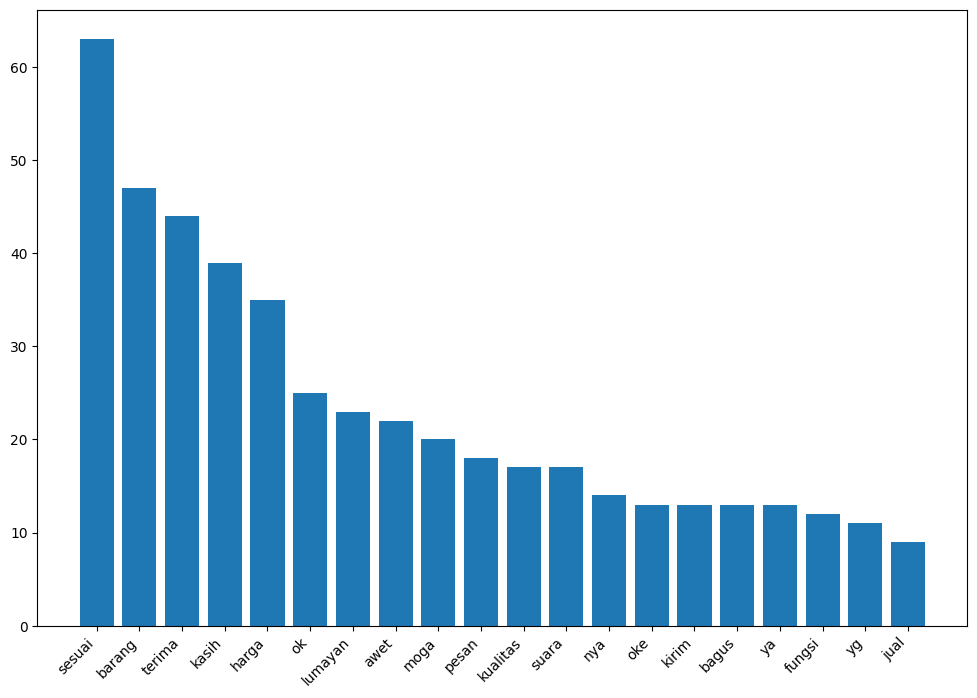

In [28]:
plt.figure(figsize=(12, 8))
plt.bar(word_count_df['Word'][:20], word_count_df['Count'][:20])
plt.xticks(rotation=45, ha='right')

([], [])

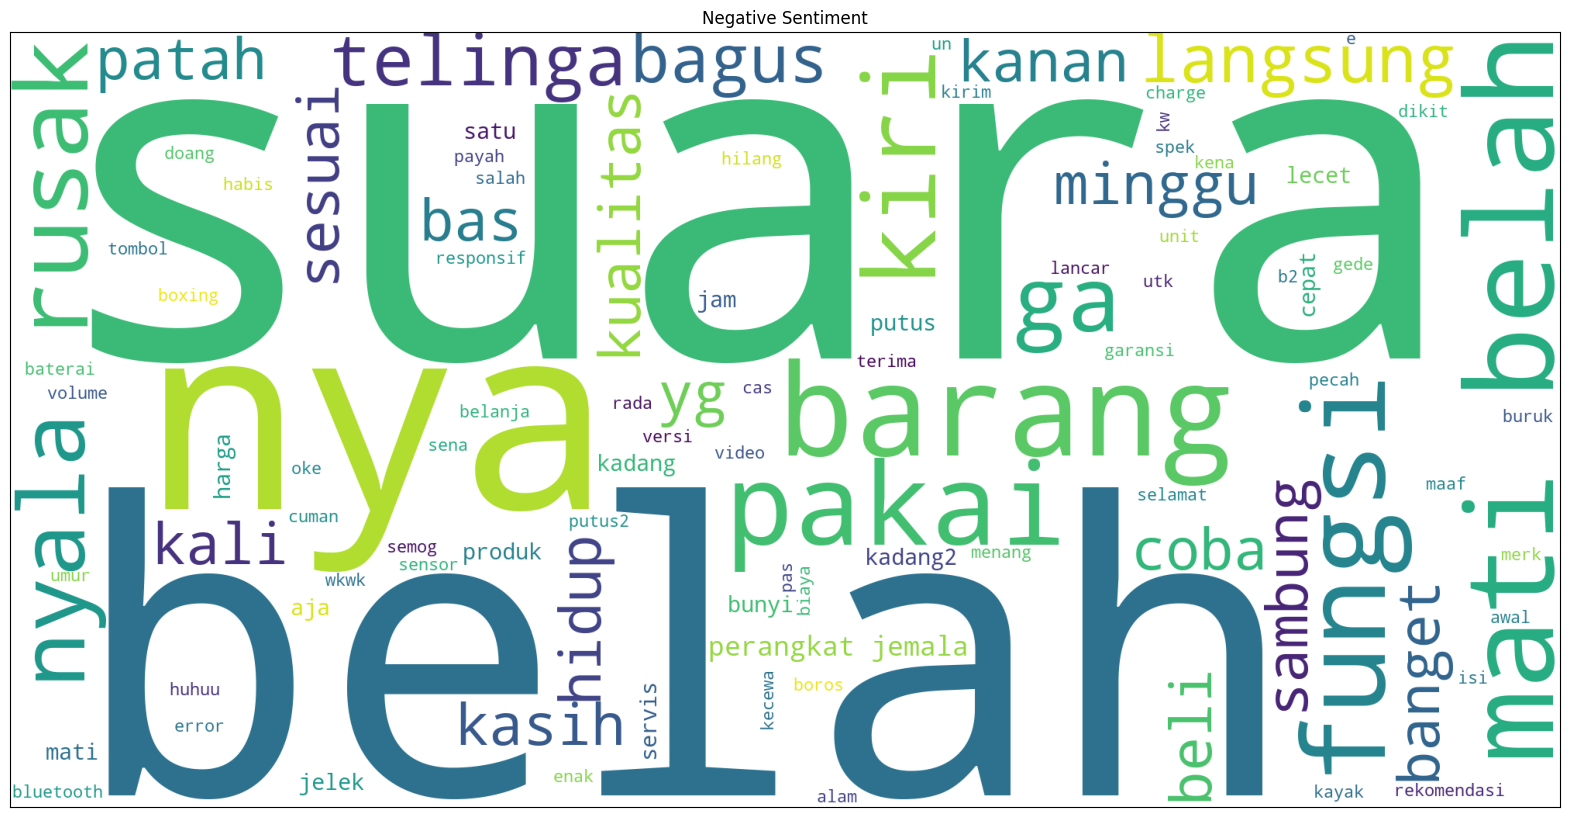

In [29]:
all_review_negatif = []
negatif_df = df[df['Sentiment'] == 0]

for kalimat in negatif_df['Review_stemmer']: 
		all_review_negatif.extend(str(kalimat).split())

wordcloud = WordCloud(width=2000,
					height=1000,
					background_color='#FFFFFF',
					max_words = 100).generate(' '.join(all_review_negatif))

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Negative Sentiment")
plt.xticks([])
plt.yticks([])

In [30]:
word_count = Counter(all_review_negatif)
word_count_df = pd.DataFrame(word_count.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

word_count_df

,Word,Count
6,belah,26
9,suara,24
14,mati,11
16,barang,10
8,nya,10
...,...,...
59,spek,1
60,boros,1
61,an,1
65,kayak,1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'belah'),
  Text(1, 0, 'suara'),
  Text(2, 0, 'mati'),
  Text(3, 0, 'barang'),
  Text(4, 0, 'nya'),
  Text(5, 0, 'pakai'),
  Text(6, 0, 'fungsi'),
  Text(7, 0, 'rusak'),
  Text(8, 0, 'kiri'),
  Text(9, 0, 'ga'),
  Text(10, 0, 'nyala'),
  Text(11, 0, 'langsung'),
  Text(12, 0, 'telinga'),
  Text(13, 0, 'bagus'),
  Text(14, 0, 'hidup'),
  Text(15, 0, 'perangkat'),
  Text(16, 0, 'bas'),
  Text(17, 0, 'kasih'),
  Text(18, 0, 'sambung'),
  Text(19, 0, 'kualitas')])

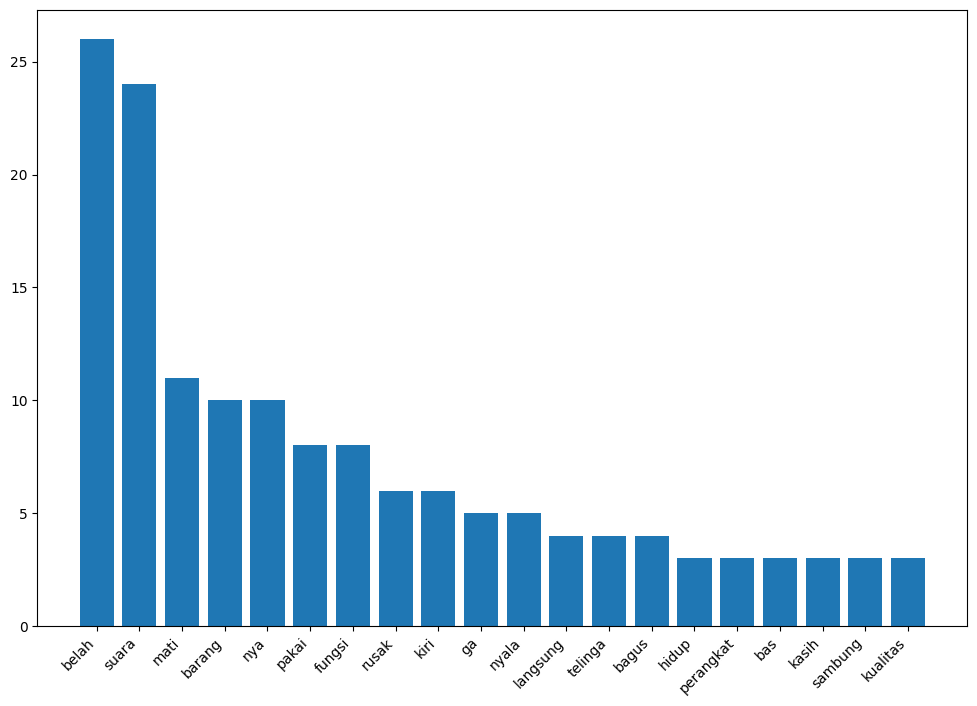

In [31]:
plt.figure(figsize=(12, 8))
plt.bar(word_count_df['Word'][:20], word_count_df['Count'][:20])
plt.xticks(rotation=45, ha='right')

## Negative, Positive, and Neutral Sentiment Classification

In [32]:
df

,Username,Rating,Variant,Review,Review_tokenize,Review_filtered,Review_stemmer,Sentiment
0,Agus,bintang 5,Varian:Biru,barang sudah sampai,"['barang', 'sudah', 'sampai']",['barang'],barang,2
1,M***d,bintang 3,Varian:Biru,cepat habis,"['cepat', 'habis']","['cepat', 'habis']",cepat habis,0
2,imron,bintang 5,Varian:Hitam,terima kasih,"['terima', 'kasih']","['terima', 'kasih']",terima kasih,2
3,Paul,bintang 5,Varian:Ungu,"Barang bagus, mengemas rapi, pengiriman cepat.","['Barang', 'bagus', ',', 'mengemas', 'rapi', '...","['Barang', 'bagus', 'mengemas', 'rapi', 'pengi...",barang bagus emas rapi kirim cepat,1
4,Y***i,bintang 1,Varian:Putih,"unit tidak bisa di charge, payah","['unit', 'tidak', 'bisa', 'di', 'charge', ',',...","['unit', 'charge', 'payah']",unit charge payah,0
...,...,...,...,...,...,...,...,...
1142,S***o,bintang 5,Varian: Putih,cepat respons,"['cepat', 'respons']","['cepat', 'respons']",cepat respons,1
1143,D***I,bintang 5,Varian: Ungu,terima kasih pengiriman perangkat jemala nya c...,"['terima', 'kasih', 'pengiriman', 'perangkat',...","['terima', 'kasih', 'pengiriman', 'perangkat',...",terima kasih kirim perangkat jemala nya cepat ...,1
1144,I***A,bintang 5,Varian: Kuning,"barang sudah diterima, cepat dan kemasan baik,...","['barang', 'sudah', 'diterima', ',', 'cepat', ...","['barang', 'diterima', 'cepat', 'kemasan', 'se...",barang terima cepat kemas moga awet pakai suks...,1
1145,R***A,bintang 5,Varian: Hijau,"baru pertama kali order disini,sangat suka dan...","['baru', 'pertama', 'kali', 'order', 'disini',...","['kali', 'order', 'suka', 'ga', 'mengecewakan']",kali order suka ga kecewa,1


In [33]:
negatif_df = df[df['Sentiment'] == 0]
positif_df = df[df['Sentiment'] == 1]
netral_df = df[df['Sentiment'] == 2]

positif_df = resample(positif_df, 
                    replace=True,   
                    n_samples=len(netral_df),    
                    random_state=1234) 

negatif_df = resample(negatif_df, 
                    replace=True,   
                    n_samples=len(netral_df),    
                    random_state=1234)

print(f'Positif sahpe = {positif_df.shape}')
print(f'Negatif sahpe = {negatif_df.shape}')
print(f'Netral sahpe = {netral_df.shape}')

Positif sahpe = (203, 8)
Negatif sahpe = (203, 8)
Netral sahpe = (203, 8)


In [34]:
balance_df = pd.concat([positif_df, negatif_df, netral_df], ignore_index=True)
balance_df

,Username,Rating,Variant,Review,Review_tokenize,Review_filtered,Review_stemmer,Sentiment
0,Akbar,bintang 5,Varian: Biru Muda,Cakep dan kereennn...,"['Cakep', 'dan', 'kereennn', '...']","['Cakep', 'kereennn', '...']",cakep kereennn,1
1,Fazri,bintang 5,Varian: Biru,"mantap, kualitas sesuai deskripsi.","['mantap', ',', 'kualitas', 'sesuai', 'deskrip...","['mantap', 'kualitas', 'sesuai', 'deskripsi']",mantap kualitas sesuai deskripsi,1
2,H***t,bintang 5,Varian: Ungu,Barang berfungsi dengan baik. Warnanya juga se...,"['Barang', 'berfungsi', 'dengan', 'baik', '.',...","['Barang', 'berfungsi', 'Warnanya', 'sesuai', ...",barang fungsi warna sesuai barang lengka mudah...,1
3,wendra,bintang 5,Varian: Hitam,barang bagus... kasi bintang 5 aja.,"['barang', 'bagus', '...', 'kasi', 'bintang', ...","['barang', 'bagus', '...', 'kasi', 'bintang', ...",barang bagus kasi bintang aja,1
4,Myta,bintang 5,Varian: Biru Muda,Mantab...,"['Mantab', '...']","['Mantab', '...']",mantab,1
...,...,...,...,...,...,...,...,...
604,m***d,bintang 5,Varian: Biru Muda,ongkos kirim sudah diganti dgn pulsa,"['ongkos', 'kirim', 'sudah', 'diganti', 'dgn',...","['ongkos', 'kirim', 'diganti', 'dgn', 'pulsa']",ongkos kirim ganti dgn pulsa,2
605,Tri,bintang 5,Varian: Hitam,lumayan oke,"['lumayan', 'oke']","['lumayan', 'oke']",lumayan oke,2
606,Yayuk,bintang 5,Varian: Biru,terima kasih barang sesuai pesanan,"['terima', 'kasih', 'barang', 'sesuai', 'pesan...","['terima', 'kasih', 'barang', 'sesuai', 'pesan...",terima kasih barang sesuai pesan,2
607,Mohamad,bintang 5,Varian: Biru,normal,['normal'],['normal'],normal,2


In [35]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(balance_df['Review_stemmer'])
y = balance_df['Sentiment']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1)

X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [37]:
model_title = ['kNN', 'Naive Bayes', 'SVM']
models = [
    (KNeighborsClassifier, {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    (SVC, {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}),
    (GaussianNB, {'var_smoothing': np.logspace(-9, -6, num=100)}),
]

accuracy = []
result = []

for i in range(len(model_title)):
    model, param = models[i]
    
    grid_model = GridSearchCV(estimator=model(), param_grid=param, cv=3, scoring='accuracy')
    grid_model.fit(X_train_array, y_train)
    
    best_model = model(**grid_model.best_params_)
    best_model.fit(X_train_array, y_train)
    
    y_pred = best_model.predict(X_test_array)
    accuracy.append(accuracy_score(y_test, y_pred))
    result.append([y_test, y_pred])

    print(f"{model_title[i]} - Best Params: {grid_model.best_params_}\n")
    print(classification_report(y_test, y_pred))

kNN - Best Params: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       0.70      0.73      0.71        44
           2       0.75      0.66      0.70        50

    accuracy                           0.76       122
   macro avg       0.77      0.80      0.78       122
weighted avg       0.76      0.76      0.76       122

Naive Bayes - Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       0.88      0.80      0.83        44
           2       0.82      0.84      0.83        50

    accuracy                           0.86       122
   macro avg       0.87      0.88      0.87       122
weighted avg       0.86      0.86      0.86       122

SVM - Best Params: {'var_smoothing': 2.477076355991714e-07}

              precision    recall  f1-

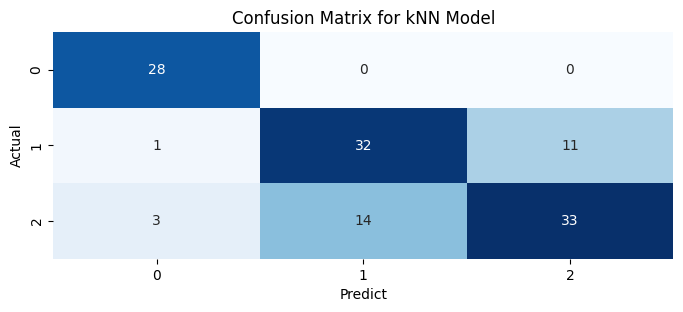

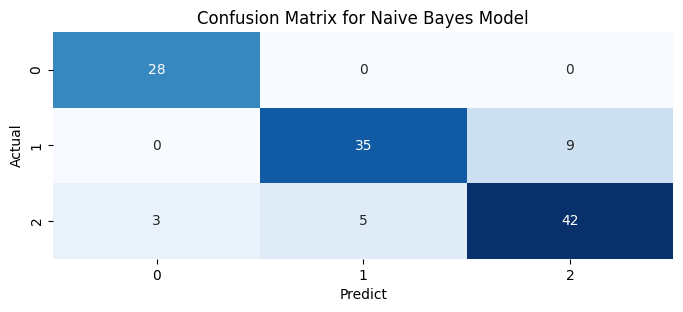

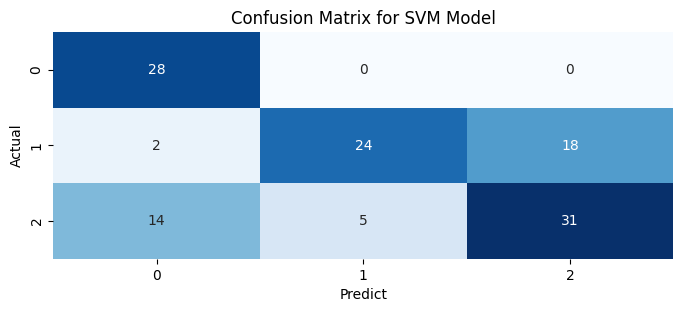

In [38]:
for i in range(len(model_title)):
    y_test, y_pred = result[i]
    confussion = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    plt.figure(figsize=(8, 10))
    plt.subplot(3, 1, i+1)
    sns.heatmap(confussion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_title[i]} Model')
    plt.xlabel('Predict')
    plt.xticks(ticks=[i + 0.5 for i in range(3)], labels=['0', '1', 2])
    plt.ylabel('Actual')
    plt.yticks(ticks=[i + 0.5 for i in range(3)], labels=['0', '1', 2])
    plt.show()

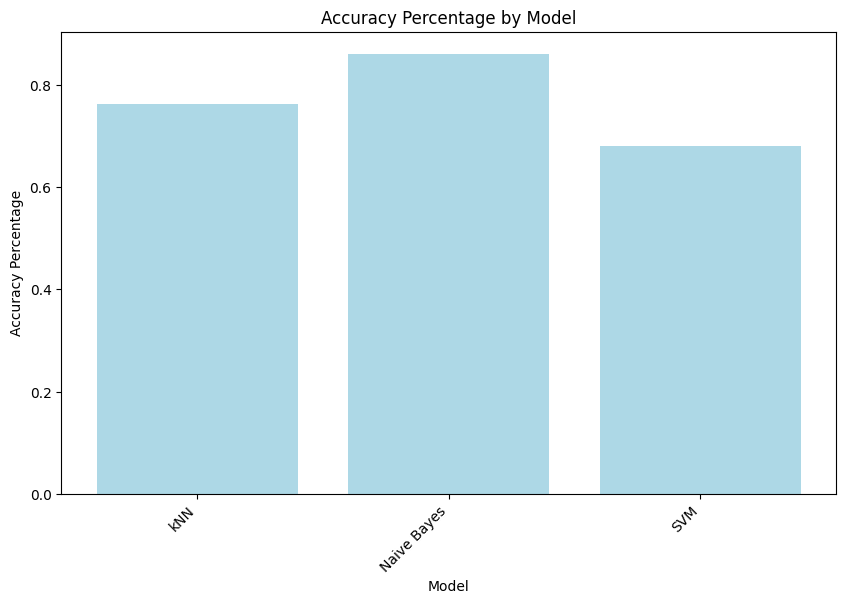

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(model_title, accuracy, color='#ADD8E6') 

plt.title('Accuracy Percentage by Model')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy Percentage')

plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(balance_df['Review_stemmer'], balance_df['Sentiment'], test_size=0.2, shuffle=True, random_state=1)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, padding='post', maxlen=20)
X_test = pad_sequences(X_test, padding='post', maxlen=20)

In [42]:
model = Sequential([
    Embedding(input_dim=50000, output_dim=5,input_length=20),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(units=64, return_sequences=True),
    LSTM(units=32),
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dropout(0.3),
    Dense(units=3, activation='sigmoid')
])

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=2, callbacks=[reduce_lr])

Epoch 1/20
16/16 - 6s - 374ms/step - accuracy: 0.3593 - loss: 1.0985 - val_accuracy: 0.2295 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 2/20
16/16 - 0s - 10ms/step - accuracy: 0.3963 - loss: 1.0937 - val_accuracy: 0.4590 - val_loss: 1.0837 - learning_rate: 0.0010
Epoch 3/20
16/16 - 0s - 11ms/step - accuracy: 0.5462 - loss: 1.0099 - val_accuracy: 0.5246 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 4/20
16/16 - 0s - 11ms/step - accuracy: 0.5873 - loss: 0.8656 - val_accuracy: 0.5328 - val_loss: 0.8133 - learning_rate: 0.0010
Epoch 5/20
16/16 - 0s - 10ms/step - accuracy: 0.6386 - loss: 0.7202 - val_accuracy: 0.5656 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 6/20
16/16 - 0s - 12ms/step - accuracy: 0.6694 - loss: 0.6097 - val_accuracy: 0.6557 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 7/20
16/16 - 0s - 12ms/step - accuracy: 0.7166 - loss: 0.5511 - val_accuracy: 0.6721 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 8/20
16/16 - 0s - 12ms/step - accuracy: 0.7556 - loss: 

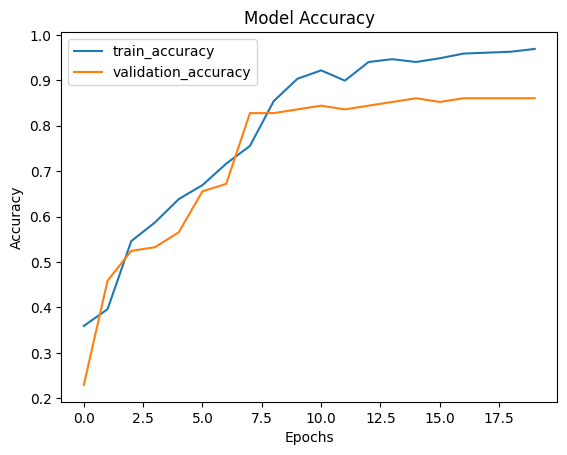

In [45]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

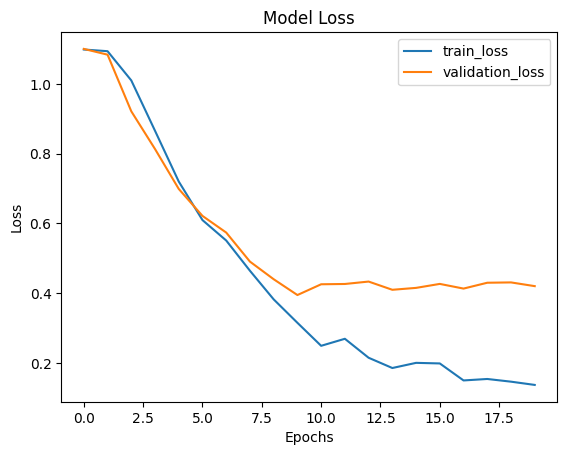

In [46]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()